In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

### 准备数据

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

100%|█████████▉| 170475520/170498071 [24:01<00:00, 238721.61it/s] 

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


170500096it [24:20, 238721.61it/s]                               

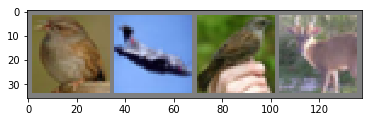

 bird plane  bird  deer


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 获取图片
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 显示图片
imshow(torchvision.utils.make_grid(images))
# 显示标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


### 构建模型

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 训练模型

In [7]:
for epoch in range(2):  # 训练N轮

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # batch数据
        inputs, labels = data

        # 梯度清零
        optimizer.zero_grad()

        # 前向
        outputs = net(inputs)
        
        # 后向
        loss = criterion(outputs, labels)
        loss.backward()
        
        # 更新参数
        optimizer.step()

        # 统计误差
        running_loss += loss.item()
        if i % 2000 == 1999:    
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('训练结束')

[1,  2000] loss: 2.189
[1,  4000] loss: 1.857
[1,  6000] loss: 1.659
[1,  8000] loss: 1.581
[1, 10000] loss: 1.506
[1, 12000] loss: 1.479
[2,  2000] loss: 1.419
[2,  4000] loss: 1.368
[2,  6000] loss: 1.349
[2,  8000] loss: 1.328
[2, 10000] loss: 1.293
[2, 12000] loss: 1.304
训练结束


### 测试

In [8]:
correct = 0
total = 0

with torch.no_grad(): 
    for data in testloader:
        # 测试数据
        images, labels = data
        
        # 预测结果
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # 准确率
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('测试集准确率: %d %%' % (100 * correct / total))

测试集准确率: 53 %


In [9]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('分类准确率：')
for i in range(10):
    print('%5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

分类准确率：
plane : 58 %
  car : 66 %
 bird : 57 %
  cat : 19 %
 deer : 40 %
  dog : 50 %
 frog : 49 %
horse : 54 %
 ship : 86 %
truck : 50 %


### GPU运算

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu
